# Preliminary Study

## global imports/setup

In [172]:
import os
import pandas as pd
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import OrderedDict
from collections.abc import Iterable

from datetime import datetime
from IPython.display import display
from scipy import stats  
from tqdm.notebook import tqdm

EO_DATE = '2025_01_20'


In [173]:

# plot the data
eo_datetime = pd.to_datetime(EO_DATE, format="%Y_%m_%d")

def generate_plots (metrics_pairs, data, save = None):
    fig, ax = plt.subplots(1, len(metrics_pairs), figsize=(10*len(metrics_pairs), 5))
    if not isinstance(ax, Iterable):
        ax = [ax]

    # set x range to start from january of earliest year
    data['date'] = pd.to_datetime(data['job_posted_date'])
    months = data['date'].dt.to_period('M')
    start_date = datetime(months.min().start_time.year, 1, 1)
    start_day = mdates.date2num(start_date)

    # choose a conversion from days -> months
    # use average month length (365.2425/12 ≈ 30.436875 days)
    days_per_month = 365.2425 / 12.0

    global_handles = OrderedDict()
    for i, metrics in enumerate(metrics_pairs):
        ax_i = ax[i]

        fit_lines = []
        for metric in metrics:
            if 'narrow' in metric:
                label = "Narrow Vocab"
                color = 'tab:blue'
            elif 'annotation' in metric:
                label = 'LLM annotation'
                color = 'tab:green'
            else:
                label = "Expanded Vocab"
                color = "tab:orange"
            data[metric] = data[metric].fillna(0)  # fill NaN proportions with 0
            monthly_means = data.groupby(months)[metric].mean()
            monthly_means.index = monthly_means.index.to_timestamp()
            plot, = ax_i.plot(monthly_means.index, monthly_means.values, marker='o', color=color)
            if len(metrics) > 1: # only add to legend if there are multiple metrics
                global_handles[label] = plot
            # ax_i.scatter(data['date'], data[metric], color=color, alpha=0.1)

            # linear regression
            x_nums = mdates.date2num(data['date'])   # floats (days since epoch)
            m, b, r_value, p_value, std_err = stats.linregress(x_nums, data[metric])
            significance = ''
            for level in [0.05,0.01,0.001]:
                if p_value < level:
                    significance += '*'
            print(f'Linear regression for {metric}: y={m:.6f}x + {b:.6f}, r^2={r_value**2:.4f}, p={p_value:.4f} {significance}, std_err={std_err:.6f}')
            # build fit line in numeric space, then convert back to dates for plotting
            y_fit = m*x_nums + b

            # also, for the label, show in terms of percents and months since start_date
            m_monthly = m * days_per_month
            b_start = m * start_day + b
            if 'proportion' in metric:
                m_monthly *= 100  # convert to percent
                b_start *= 100
            fit, = ax_i.plot(x_nums, y_fit, color=color, alpha = 0.7, label=f'{significance}y={m_monthly:.3f}x{"+" if b_start > 0 else ""}{b_start:.3f}, $r^2$={r_value**2:.4f}')
            fit_lines.append(fit)
        ax_i.legend(handles=fit_lines, loc='upper left', fontsize=12)

        # ax_i.set_xlabel('Date')
        ax_i.set_xlim(left=start_date) 
        plt.setp( ax_i.xaxis.get_majorticklabels(), rotation=45, ha="right" )

        ax_i.set_ylim(bottom=0)

        title = ''
        if 'proportion' in metrics[0]: # convert decimal tick labels to percent
            ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])
            ax_i.set_title('Average Proportion of Document being DEI Words', fontsize=18)
        elif 'annotation' in metrics[0]:
            ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])
            ax_i.set_title('Proportion of Documents containing DEI Sentiment (binary)', fontsize=18)
        else:
            ax_i.set_title('Average Number of DEI Words Per Document', fontsize=18)
        ax_i.tick_params(axis='y', labelsize=12)
        # ax_i.set_ylabel(f'Average {"# Occurrences" if "count" in metric1 else "Proportion of Words"}', fontsize=16)
        ax_i.grid()
        # ax_i.legend(fontsize=14)
        # add eo date line
        eo = ax_i.axvline(eo_datetime, color='red', linestyle='--')
        global_handles['Executive Orders'] = eo
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles=list(global_handles.values()),
            labels=list(global_handles.keys()), 
            ncol=len(global_handles), 
            loc='lower center', 
            bbox_to_anchor=(0.5, -0.12), 
            fontsize=14,)
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

In [174]:
before = pd.read_csv('data/before.csv')
before['locality'] = before['location'].str.split(', ').str[0]
before['region'] = before['location'].str.split(', ').str[1]
before.drop(columns=['location'], inplace=True)
# display(before.head())

# print(before['description'].iloc[0])

after = pd.read_csv('data/after.csv', index_col=0)
# display(after.head())

In [175]:
if os.path.exists('data/merged.csv'):
    merged = pd.read_csv('data/merged.csv')
else:
    # merge datasets on common columns
    rename_map_before = {
        'title': 'job_title',
        'locality': 'company_address_locality',
        'region': 'company_address_region',
        'publishedAt': 'job_posted_date',
        'companyName': 'company_name',
        'description': 'job_description_text',
        'experienceLevel': 'seniority_level',
        'applicationsCount': 'num_applications',
        'contractType': 'contract_type',
        'workType': 'work_type'
    }

    before = before.rename(columns=rename_map_before)

    common_columns = [col for col in before.columns if col in after.columns]

    merged = pd.concat([before, after], ignore_index=True)
    display(merged.head())

    # save merged dataset
    merged.dropna(inplace=True, subset=['job_description_text', 'job_posted_date'], how='any')
    merged.to_csv('data/merged.csv', index=False)
display(merged.head())

,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,company_address_locality,company_address_region,company_website,company_description,manual_annotation,manual_minimum_degree,auto_annotation_comment,auto_annotation
0,AI/ML Engineer,2024-05-29,Wesper,THE OPPORTUNITY\n\nWesper is looking for a sma...,Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,New York,NY,NaN,NaN,NaN,NaN,CATEGORIZATION: 0,0
1,ML Engineer at 100% Remote,2024-06-01,ELITE MENTE LLC,"Hello ,\n\nHope you are doing well!\n\nPlease ...",Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Staffing and Recruiting,San Jose,CA,NaN,NaN,NaN,NaN,CATEGORIZATION: 0,0
2,Machine Learning Engineer (L4) - Infrastructur...,2024-05-19,Netflix,At Netflix our goal is to entertain the world....,Over 200 applicants,Full-time,Not Applicable,Engineering and Information Technology,"Entertainment Providers, Technology, Informati...",Los Gatos,CA,NaN,NaN,NaN,NaN,CATEGORIZATION: 1,1
3,ML Engineer-AI/ML,2024-04-30,Zortech Solutions,"Role: ML Engineer-AI/ML\n\nLocation: Austin, T...",67 applicants,Full-time,Entry level,Engineering and Information Technology,Human Resources Services,Austin,TX,NaN,NaN,NaN,NaN,CATEGORIZATION: 0,0
4,ML/ Machine Learning/ Data Scientist/ AI/ Arti...,2024-05-20,HatchPros,"T+S\n\nUSC/GC\n\nNeed VISA, DL and LinkedIn\n\...",145 applicants,Contract,Mid-Senior level,Engineering and Information Technology,IT Services and IT Consulting,Richardson,TX,NaN,NaN,NaN,NaN,CATEGORIZATION: 0,0


In [176]:
# regularize job description text
def regularize_text(text):
    if pd.isna(text):
        return ''
    text = text.lower() # lowercase
    text = re.sub(r'[^a-z\d\s]', ' ', text) # remove non-alphanumeric, non-space characters
    # text = re.sub(r'\.(\s|$)', ' ', text) # replace ending periods with spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
merged['description_reg'] = merged['job_description_text'].apply(regularize_text)
print(merged['description_reg'].iloc[80])

about ascendion ascendion is a full service digital engineering solutions company we make and manage software platforms and products that power growth and deliver captivating experiences to consumers and employees our engineering cloud data experience design and talent solution capabilities accelerate transformation and impact for enterprise clients headquartered in new jersey our workforce of 6 000 ascenders delivers solutions from around the globe ascendion is built differently to engineer the next ascendion engineering to elevate life we have a culture built on opportunity inclusion and a spirit of partnership come change the world with us build the coolest tech for world s leading brands solve complex problems and learn new skill experience the power of transforming digital engineering for fortune 500 clients master your craft with leading training programs and hands on experience experience a community of change makers join a culture of high performing innovators with endless idea

## eda

In [177]:
# summary statistics
before_all = before.shape[0]
before_distinct = before.nunique()
before_missing = before.isnull().sum()
before_sum = pd.DataFrame({'total_rows': before_all, 'distinct_values': before_distinct, 'missing_values': before_missing})
display(before_sum)

after_all = after.shape[0]
after_distinct = after.nunique()
after_missing = after.isnull().sum().T
after_sum = pd.DataFrame({'total_rows': after_all, 'distinct_values': after_distinct, 'missing_values': after_missing})
display(after_sum)


,total_rows,distinct_values,missing_values
title,862,450,0
publishedAt,862,142,12
companyName,862,519,1
description,862,748,0
applicationsCount,862,145,0
contractType,862,5,0
experienceLevel,862,7,0
workType,862,55,0
sector,862,156,3
locality,862,159,0


,total_rows,distinct_values,missing_values
job_posted_date,997,116,0
company_address_locality,997,178,47
company_address_region,997,87,113
company_name,997,488,0
company_website,997,478,14
company_description,997,480,12
job_description_text,997,795,1
seniority_level,997,7,9
job_title,997,450,0


<Figure size 1200x600 with 0 Axes>

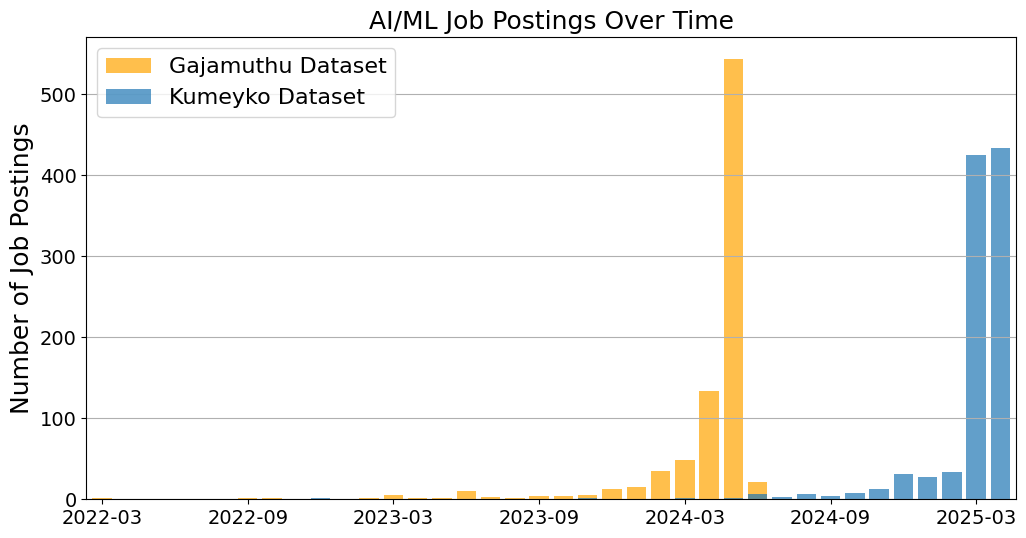

In [178]:
# total number of job postings over time, combining both datasets into one
plt.figure(figsize=(12, 6))
before['date'] = pd.to_datetime(before['publishedAt'])
after['date'] = pd.to_datetime(after['job_posted_date'])
merged['date'] = pd.to_datetime(merged['job_posted_date'])

before_counts = before['date'].dropna().dt.to_period('M').value_counts().sort_index()
after_counts = after['date'].dropna().dt.to_period('M').value_counts().sort_index()

min_date = min(before['date'].min(), after['date'].min())
max_date = max(before['date'].max(), after['date'].max())
# Generate ALL months in the range
all_months = pd.period_range(
    start=pd.Period(min_date, freq='M'),
    end=pd.Period(max_date, freq='M'),
    freq='M'
)

before_counts = before_counts.reindex(all_months, fill_value=0)
after_counts = after_counts.reindex(all_months, fill_value=0)

# combine the two series by date
# total_counts = before_counts.add(after_counts, fill_value=0)
# total_counts = total_counts.sort_index()
# plt.plot(total_counts.index, total_counts.values, marker='o', label='Total Job Postings')
# plt.bar(before_counts.index, before_counts.values, label='Gajamuthu Dataset')
# plt.bar(after_counts.index, after_counts.values, label='Kumeyko Dataset')
fig, ax = plt.subplots(figsize=(12, 6))
before_counts.plot(kind='bar', label='Gajamuthu Dataset', color='orange', alpha=0.7, ax=ax, width=0.8)
after_counts.plot(kind='bar', label='Kumeyko Dataset', alpha=0.7, ax=ax, width=0.8)
# set x axis range to be the union of both datasets
# ax.set_xlim(min(before_counts.index.min(), after_counts.index.min()), max(before_counts.index.max(), after_counts.index.max()))
plt.legend(fontsize=16)
plt.title('AI/ML Job Postings Over Time', fontsize=18)
# plt.xlabel('Date')
x_labels = all_months.astype(str)
ax.set_xticks(np.arange(len(x_labels), step=6)) 
ax.set_xticklabels(x_labels[::6], rotation=0, ha='center', fontsize=14)
plt.ylabel('Number of Job Postings', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
plt.grid(axis='y')
plt.show()

## word processing
Dictionary-based method, calculating word frequency heuristics.

In [179]:
# put job descriptions into a single list for word processing
descriptions = merged['description_reg'].dropna().str.split().tolist()
print(f'Total number of job descriptions: {len(descriptions)}')
print(descriptions[0])

Total number of job descriptions: 1846
['the', 'opportunity', 'wesper', 'is', 'looking', 'for', 'a', 'smart', 'and', 'creative', 'engineer', 'to', 'lead', 'our', 'ai', 'ml', 'efforts', 'and', 'product', 'initiatives', 'this', 'includes', 'advanced', 'ml', 'modeling', 'for', 'large', 'scale', 'healthcare', 'data', 'synthesis', 'deep', 'physiological', 'signal', 'optimization', 'pipelines', 'and', 'generative', 'ai', 'architectures', 'the', 'right', 'candidate', 'will', 'have', 'an', 'opportunity', 'to', 'research', 'design', 'and', 'implement', 'novel', 'solutions', 'alongside', 'the', 'software', 'team', 'and', 'serve', 'as', 'a', 'subject', 'matter', 'expert', 'on', 'all', 'artificial', 'intelligence', 'matters', 'for', 'the', 'company', 'reports', 'into', 'vp', 'r', 'd', 'responsibilities', 'work', 'with', 'cto', 'vp', 'r', 'd', 'and', 'software', 'leadership', 'to', 'shape', 'and', 'commercialize', 'wesper', 's', 'ai', 'ml', 'strategy', 'design', 'and', 'implement', 'feature', 'engi

In [180]:
vocab = set([w for desc in descriptions for w in desc])
print(f'Total vocabulary size: {len(vocab)}')

Total vocabulary size: 21114


In [181]:
if os.path.exists("data/dei_terms.json"):
    with open('data/dei_terms.json', 'r') as f:
        dei = json.load(f)
        dei_narrow = dei['narrow']
        dei_expanded = dei['expanded']
    print(f"Loaded DEI terms from file. {len(dei_narrow)} narrow terms, {len(dei_expanded)} expanded terms.")

else:
    dei_narrow = ["dei", "diversity", "diverse", "equity", "equitable", "inclusion", "inclusive"]
    negative = ['finance', 'financial', 'fiscal', 'economic', 'expensive', 'expense', 'profit', 'pay', 'salary'] # exclude the other meaning of "equity"

    # get the 20 most similar words by word2vec for each of the DEI_NARROW terms
    from gensim.models import Word2Vec
    if not os.path.exists("word2vec.model"):
        model = Word2Vec(sentences=descriptions, vector_size=100, window=5, min_count=1, workers=4)
        model.save("word2vec.model")

    model = Word2Vec.load("word2vec.model")
    dei_expanded = set(dei_narrow)
    # similarities = {}
    for term in dei_narrow:
        if term in model.wv:
            # similarities[term] = {}
            similar_words = model.wv.most_similar(term, topn=50)
            for word, similarity in similar_words:
                if similarity < 0.6:
                    continue
                dei_expanded.add(word)
                    # similarities[term][word] = similarity
    for word in list(dei_expanded): # filter out financial words from expanded list
        for neg in negative: 
            if (word == neg) or (model.wv.similarity(word, neg) > 0.5):
                # print(f'Removed {word} due to similarity to negative term {neg}')
                dei_expanded.remove(word)
                break
    print(f"{len(dei_expanded)} Expanded DEI terms:", dei_expanded)
    dei_expanded = list(dei_expanded)
    dei = {'narrow': dei_narrow, 'expanded': dei_expanded}
    with open('data/dei_terms.json', 'w') as f:
        json.dump(dei, f, indent=4)

Loaded DEI terms from file. 7 narrow terms, 81 expanded terms.


In [182]:
print('"'+'", "'.join(sorted(dei_expanded))+'"')

"act", "actqualtrics", "adaptable", "aim", "altos", "amazing", "amazonians", "aspxcommitment", "atelio", "atmosphere", "backgrounds", "belonging", "belongs", "benefitscompetitive", "celebrate", "celebrates", "celebrating", "celonis", "collaborative", "commitment", "committed", "communicative", "communities", "competitive", "creating", "cultivating", "culture", "dedication", "dibe", "differences", "diverse", "diversity", "embrace", "embraces", "embracing", "empathetic", "employer", "empowering", "encourages", "entrepreneurial", "equal", "equality", "equitable", "ethical", "foster", "fostering", "free", "fun", "gives", "grant", "gritty", "happiness", "honesty", "inclusion", "inclusive", "inclusivity", "inspired", "intentionally", "packagecompetitive", "personify", "pluspaypal", "promote", "providing", "remarkable", "respect", "respectful", "retaining", "rewarding", "sales", "society", "spirit", "stayed", "strive", "stronger", "supportive", "values", "viewpoints", "voices", "welcoming", "

In [183]:
# get frequencey of DEI terms in job descriptions
for term in dei_narrow + dei_expanded:
    merged[f'{term}_count'] = merged['description_reg'].str.count(term) #.apply(lambda x: x.count(term))

# sum up category counts
merged['dei_narrow_count'] = merged[[f'{term}_count' for term in dei_narrow]].sum(axis=1)
merged['dei_expanded_count'] = merged[[f'{term}_count' for term in dei_expanded]].sum(axis=1)

# total word counts
merged['total_word_count'] = merged['description_reg'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# dei proportions
merged['dei_narrow_proportion'] = merged['dei_narrow_count'] / merged['total_word_count']
merged['dei_expanded_proportion'] = merged['dei_expanded_count'] / merged['total_word_count']

# save word counts
merged.to_csv('data/merged.csv')

Linear regression for dei_narrow_count: y=0.001701x + -32.212888, r^2=0.0200, p=0.0000 ***, std_err=0.000277
Linear regression for dei_expanded_count: y=0.012788x + -242.616218, r^2=0.0519, p=0.0000 ***, std_err=0.001273
Linear regression for dei_narrow_proportion: y=0.000001x + -0.013482, r^2=0.0020, p=0.0570 , std_err=0.000000
Linear regression for dei_expanded_proportion: y=0.000007x + -0.129020, r^2=0.0159, p=0.0000 ***, std_err=0.000001


/tmp/ipykernel_103899/1131462451.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])


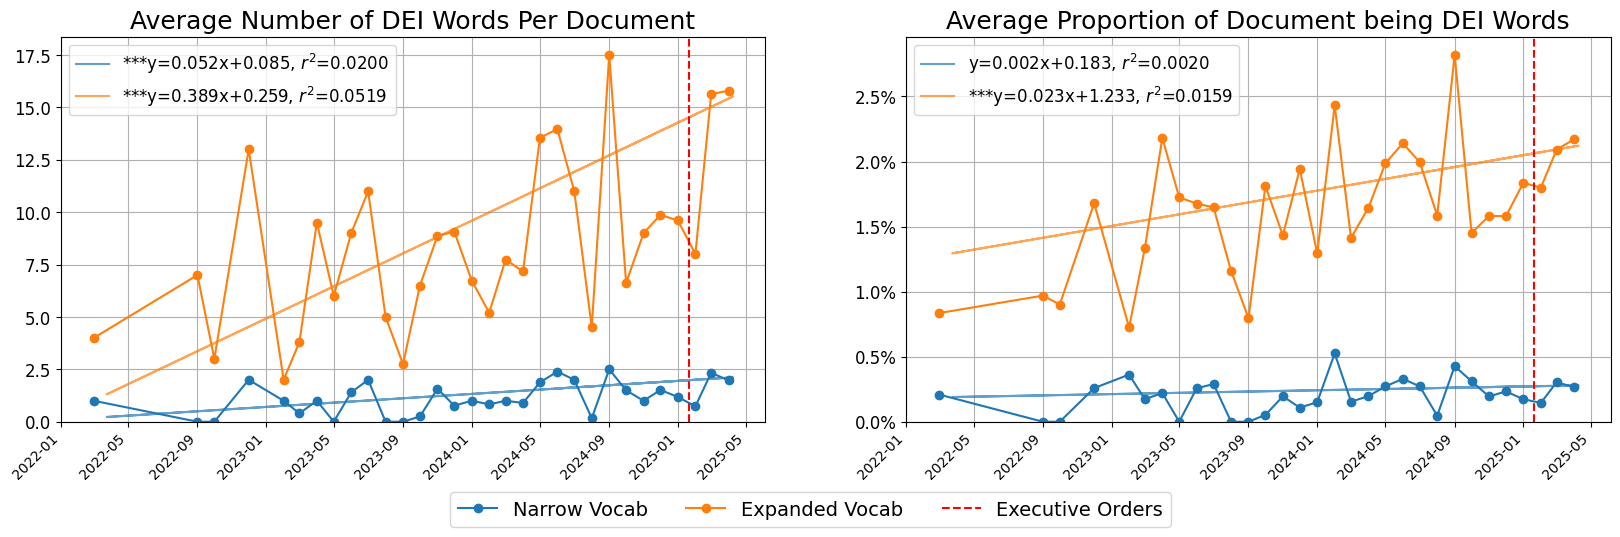

In [184]:
# plot the two proportions together and the two counts together
metrics_pairs = [
    ('dei_narrow_count', 'dei_expanded_count'),
    ('dei_narrow_proportion', 'dei_expanded_proportion')
]

generate_plots(metrics_pairs, merged, save='figures/word_counts.png')

## LLM processing
Annotating for holistic DEI sentiment, using GPT-5 nano.

In [185]:
merged = pd.read_csv('data/merged.csv')
print(merged.shape)
merged.head()

(1846, 108)


,Unnamed: 0,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,...,dedication_count,viewpoints_count,foster_count,fun_count,gritty_count,dei_narrow_count,dei_expanded_count,total_word_count,dei_narrow_proportion,dei_expanded_proportion
0,0,AI/ML Engineer,2024-05-29,Wesper,THE OPPORTUNITY\n\nWesper is looking for a sma...,Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,...,0,0,0,0,0,1,4,490,0.002041,0.008163
1,1,ML Engineer at 100% Remote,2024-06-01,ELITE MENTE LLC,"Hello ,\n\nHope you are doing well!\n\nPlease ...",Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Staffing and Recruiting,...,0,0,0,0,0,0,4,119,0.000000,0.033613
2,2,Machine Learning Engineer (L4) - Infrastructur...,2024-05-19,Netflix,At Netflix our goal is to entertain the world....,Over 200 applicants,Full-time,Not Applicable,Engineering and Information Technology,"Entertainment Providers, Technology, Informati...",...,0,0,0,0,0,4,11,621,0.006441,0.017713
3,3,ML Engineer-AI/ML,2024-04-30,Zortech Solutions,"Role: ML Engineer-AI/ML\n\nLocation: Austin, T...",67 applicants,Full-time,Entry level,Engineering and Information Technology,Human Resources Services,...,0,0,0,2,0,0,3,230,0.000000,0.013043
4,4,ML/ Machine Learning/ Data Scientist/ AI/ Arti...,2024-05-20,HatchPros,"T+S\n\nUSC/GC\n\nNeed VISA, DL and LinkedIn\n\...",145 applicants,Contract,Mid-Senior level,Engineering and Information Technology,IT Services and IT Consulting,...,0,0,0,0,0,0,2,577,0.000000,0.003466


### manual labels

In [186]:
# do a validation sample of manual annotations
VAL_SIZE = 50
if 'manual_annotation' not in merged.columns:
    merged['manual_annotation'] = pd.Series(dtype=int)
    merged['manual_minimum_degree'] = pd.Series(dtype=str)
if merged['manual_annotation'].isnull().all():
    merged.loc[val_sample.index, 'manual_annotation'] = -1  # placeholder for manual annotation
    merged.to_csv('data/merged.csv', index=False)
val_sample = merged[merged['manual_annotation'].notna()]

In [187]:
val_sample.head()

,Unnamed: 0,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,...,dedication_count,viewpoints_count,foster_count,fun_count,gritty_count,dei_narrow_count,dei_expanded_count,total_word_count,dei_narrow_proportion,dei_expanded_proportion
27,27,AI/ML Engineer,2024-04-30,Dwebtech Consulting Inc.,"Title: AI/ML Engineer\n\nLocation: Rutherford,...",134 applicants,Contract,Mid-Senior level,Engineering and Information Technology,Staffing and Recruiting,...,0,0,0,2,0,0,5,198,0.000000,0.025253
31,31,ARTIFICIAL INTELLIGENCE (AI)/MACHINE LEARNING ...,2024-05-22,"Infinite Management Solutions, LLC","Job Title: AI/ML Engineer\n\nLocation: Dayton,...",Be among the first 25 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,...,1,0,0,3,0,1,22,971,0.001030,0.022657
52,52,Deep Learning Engineer,2024-04-29,"Matroid, Inc.",About Matroid\n\nWith the rapid growth of arti...,Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Software Development,...,0,0,0,0,0,2,13,694,0.002882,0.018732
60,60,Data Scientist,2024-05-17,Ascendion,About Ascendion\n\nAscendion is a full-service...,Over 200 applicants,Full-time,Mid-Senior level,Information Technology and Engineering,Banking and Financial Services,...,0,0,0,0,0,2,10,509,0.003929,0.019646
61,61,Machine Learning Engineer,2024-05-25,HackerPulse,Showcase your software engineering talents usi...,Over 200 applicants,Full-time,Entry level,Engineering and Information Technology,Software Development,...,0,0,0,0,0,0,1,173,0.000000,0.005780


In [188]:

val_sample = merged[merged['manual_annotation'].notna()]
for i, row in val_sample.iterrows():
    if row['manual_annotation'] == -1:
        with open('temp', 'w') as f:
            f.write(f'Row {i}:\n\n'+row['job_description_text'])
        annotation = input(f"Please provide manual annotation for job posting {i} (0=non-DEI, 1=DEI (including EEO)):")
        merged.at[i, 'manual_annotation'] = int(annotation)
        degree = input(f"Please provide minimum degree required for job posting {i} (b=Bachelor's, m=Master's', p=PhD, e='equivalent experience', n=None):")
        merged.at[i, 'manual_minimum_degree'] = degree


In [189]:
merged.to_csv('data/merged.csv', index=False)
(merged['manual_annotation'].value_counts(), merged['manual_minimum_degree'].value_counts())

(manual_annotation
 0.0    26
 1.0    24
 Name: count, dtype: int64,
 manual_minimum_degree
 b    25
 n    18
 m     4
 e     3
 Name: count, dtype: int64)

### LLM querying

In [190]:
from openai import OpenAI

OPENAI_MODELS = ['gpt-5-nano-2025-08-07']

openai_client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

SYSTEM = "You are a text processing assistant for a recruiting and human resources company, helping them process job postings. They are classifying job postings according to a few characteristics. Each user message contains the description of a single characteristic and a job posting text. You will respond with the classification of the job posting according to the description."
PROMPTS = {'dei': ("""\
CHARACTERISTIC: Diversity, Equity, and Inclusion (DEI) Sentiment
DESCRIPTION: The job posting contains information encouraging diversity in applicants. For example, mention of a welcoming workplace, emphasis on diverse perspectives, and statement of inclusive policies, such as affirmative action and Equal Employment Opportunity/being an Equal Opportunity Employer.
CATEGORIZATION: 1 (includes DEI sentiment), 0 (does not include DEI sentiment)
JOB POSTING:
\"\"\"
{text}
\"\"\" 
Think step-by-step and then respond wth "CATEGORIZATION:" followed by your categorization (only 0 or 1).
""",('0','1')),
}

In [191]:
MAX_LENGTH = 500
LLM = 'gpt-5-nano-2025-08-07'

def render_prompt(template, text):
    prompt = template
    prompt = prompt.replace("{text}", text)
    return [{"role":"system","content": SYSTEM}, {"role":"user","content": prompt}]

def extract_category (response, valid_vals):
    categ = response.split("CATEGORIZATION:")[-1].strip()
    found = {}
    for val in valid_vals:
        i = categ.find(val)
        if i == 0:
            return int(val)
        if i < 0:
            continue
        found[i] = val
    if len(found) < 1: # no valid vals found
        raise ValueError(f"The response does not contain a valid value. Must be one of {valid_vals}.\nResponse text:{response}")
    return found[min(found)] # find the earliest stated value

def categorize_single (text, feature='dei', llm=LLM): 
    template, valid_vals = PROMPTS[feature]
    messages = render_prompt(template, text)
    response = openai_client.chat.completions.create(messages=messages,
                                                    model=LLM,
                                                    temperature = 0,
                                                    max_tokens= MAX_LENGTH)
    response_text = response.choices[0].message.content.strip()
    category = extract_category(response_text, valid_vals)
    return category

In [192]:
# batch?
feature = 'dei'
tasks = []

template, valid_vals = PROMPTS[feature]

for index, row in merged.iterrows():
    text = row['job_description_text']
    task = {
        "custom_id": f"row-{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            # This is what you would have in your Chat Completions API call
            "model": LLM,
            "messages":render_prompt(template, text)
        }
    }
    
    tasks.append(task)
print(len(tasks), merged.shape)

def estimate_tokens (messages): # estimate 2x number of words
    words = 0
    for message in messages:
        words += len(message['content'].split())
    return 3*words

total_tokens = sum([estimate_tokens(task['body']['messages']) for task in tasks])
print(total_tokens)

file_name = "data/batch_tasks_dei.jsonl"
with open(file_name, 'w') as file:
    for obj in tasks:
        file.write(json.dumps(obj) + '\n')

1846 (1846, 108)
3991944


In [193]:
# too long, so split into multiple files
tasks_first = []
tasks_second = []
first_tokens = 0
i = -1
while first_tokens < 2_000_000:
    i += 1
    task = tasks[i]
    first_tokens += estimate_tokens(task['body']['messages'])
    tasks_first.append(task)
tasks_first = tasks_first[:-1]
tasks_second = tasks[i:]

for i, t in enumerate([tasks_first, tasks_second]):
    file_name = f"data/batch_tasks_dei_{i}.jsonl"
    with open(file_name, 'w') as file:
        for obj in t:
            file.write(json.dumps(obj) + '\n')

In [194]:
# for file_name in ["data/batch_tasks_dei_0.jsonl","data/batch_tasks_dei_1.jsonl"]:
#   batch_file = openai_client.files.create(
#     file=open(file_name, "rb"),
#     purpose="batch"
#   )
#   print(batch_file)

FileObject(id='file-1yzjdghALUyu1e3Z3j1vE5', bytes=4935058, created_at=1764310461, filename='batch_tasks_dei_0.jsonl', object='file', purpose='batch', status='processed', expires_at=1766902461, status_details=None)

FileObject(id='file-6M5o16cGD8oY3XQ8gvkXWc', bytes=5016239, created_at=1764310464, filename='batch_tasks_dei_1.jsonl', object='file', purpose='batch', status='processed', expires_at=1766902464, status_details=None)

In [195]:
# REQUEST JOB
BATCH_FILE = 'file-34Zh1nBTwuGDsu54xrgkvr'
BATCH_FILE_0 = 'file-1yzjdghALUyu1e3Z3j1vE5'
BATCH_FILE_1 = 'file-6M5o16cGD8oY3XQ8gvkXWc'

# batch_job = openai_client.batches.create(
#   input_file_id=BATCH_FILE,
#   endpoint="/v1/chat/completions",
#   completion_window="24h"
# )
# batch_job_1 = openai_client.batches.create(
#   input_file_id=BATCH_FILE_1,
#   endpoint="/v1/chat/completions",
#   completion_window="24h"
# )
# batch_job_1 = openai_client.batches.create(
#   input_file_id=BATCH_FILE_1,
#   endpoint="/v1/chat/completions",
#   completion_window="24h"
# )
print(batch_job_1)

Batch(id='batch_692a2dbd63848190bf8554221644fc40', completion_window='24h', created_at=1764371901, endpoint='/v1/chat/completions', input_file_id='file-6M5o16cGD8oY3XQ8gvkXWc', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1764458301, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, model=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), usage=BatchUsage(input_tokens=0, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=0, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=0))


#### tasks_first:
Batch(id='batch_69293e36aa088190a41882c41d88cf09', completion_window='24h', created_at=1764310582, endpoint='/v1/chat/completions', input_file_id='file-1yzjdghALUyu1e3Z3j1vE5', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1764396982, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, model=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), usage=BatchUsage(input_tokens=0, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=0, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=0))

#### tasks_second:
Batch(id='batch_692a2dbd63848190bf8554221644fc40', completion_window='24h', created_at=1764371901, endpoint='/v1/chat/completions', input_file_id='file-6M5o16cGD8oY3XQ8gvkXWc', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1764458301, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, model=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), usage=BatchUsage(input_tokens=0, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=0, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=0))

In [196]:
BATCH_ID = 'batch_69291414c598819091965d0ff65ef63a'
BATCH_ID_0 = 'batch_69293e36aa088190a41882c41d88cf09'
BATCH_ID_1 = 'batch_692a2dbd63848190bf8554221644fc40'
batch_job = openai_client.batches.retrieve(BATCH_ID_1)
print(batch_job)

Batch(id='batch_692a2dbd63848190bf8554221644fc40', completion_window='24h', created_at=1764371901, endpoint='/v1/chat/completions', input_file_id='file-6M5o16cGD8oY3XQ8gvkXWc', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1764372161, error_file_id=None, errors=None, expired_at=None, expires_at=1764458301, failed_at=None, finalizing_at=1764372120, in_progress_at=1764371963, metadata=None, model='gpt-5-nano-2025-08-07', output_file_id='file-MvkoigJFB1aNYT3whSfcbn', request_counts=BatchRequestCounts(completed=874, failed=0, total=874), usage=BatchUsage(input_tokens=892017, input_tokens_details=InputTokensDetails(cached_tokens=11776), output_tokens=227305, output_tokens_details=OutputTokensDetails(reasoning_tokens=214144), total_tokens=1119322))


### read results

In [197]:
out_0 = 'data/tasks_dei_0_output.jsonl'
out_1 = 'data/tasks_dei_1_output.jsonl'

df_out = []

with open(out_0, 'r') as f:
    for line in f.readlines():
        response = json.loads(line) 
        df_out.append({'id': response['custom_id'], 'content':response['response']['body']['choices'][0]['message']['content']})


with open(out_1, 'r') as f:
    for line in f.readlines():
        response = json.loads(line) 
        df_out.append({'id': response['custom_id'], 'content':response['response']['body']['choices'][0]['message']['content']})

df_out = pd.DataFrame(df_out)
df_out.head()
assert all(df_out)


In [198]:
# check that 'id' column matches f'row-{index}' for all rows
assert all(df_out['id'].str.split('row-').str[-1] == df_out.index.astype(str))

# add the auto annotation column
merged['auto_annotation_comment'] = df_out['content']
merged['auto_annotation'] = merged['auto_annotation_comment'].str.split(': ').str[-1].str.strip().astype(int)

In [199]:
# check agreement over manually annotated rows
print((merged['manual_annotation'] == merged['auto_annotation'])[merged['manual_annotation'] > -1].value_counts()/50)

# inspect disagreements
display(merged[(merged['manual_annotation'] > -1) & (merged['manual_annotation'] != merged['auto_annotation'])])

# check aggregate discrepancies
(merged[merged['manual_annotation'] > -1]['manual_annotation'].value_counts() - merged[merged['manual_annotation'] > -1]['auto_annotation'].value_counts())/50

True     0.9
False    0.1
Name: count, dtype: float64


,Unnamed: 0,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,...,dedication_count,viewpoints_count,foster_count,fun_count,gritty_count,dei_narrow_count,dei_expanded_count,total_word_count,dei_narrow_proportion,dei_expanded_proportion
108,108,ML Engineer,2023-06-05,Spline,Hello there! At Spline (twitter.com/splinetool...,Over 200 applicants,Full-time,Entry level,Engineering and Information Technology,Design Services,...,0,0,0,1,0,1,3,227,0.004405,0.013216
474,474,Machine Learning 3,2024-05-08,Nike,"Work options: Remote\n\nFully remote, working ...",77 applicants,Contract,Mid-Senior level,Engineering and Information Technology,Retail,...,0,0,0,0,0,1,6,312,0.003205,0.019231
835,835,Principle AI/ML Engineer,2024-05-31,Cherish,About Us‬\n\n‭Cherish is developing groundbrea...,45 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Health and Human Services,...,0,0,1,3,0,0,23,1375,0.000000,0.016727
954,954,Machine Learning Engineer,2025-03-13,Hedra,Hedra is a pioneering generative media company...,NaN,NaN,Entry level,NaN,NaN,...,0,0,0,1,0,3,8,457,0.006565,0.017505
1738,1738,Machine Learning Data Engineer,2025-04-02,Motion Recruitment,Machine Learning Data Engineer12 Month Contrac...,NaN,NaN,Mid-Senior level,NaN,NaN,...,0,0,0,0,0,0,5,487,0.000000,0.010267


manual_annotation
0.0    0.02
1.0   -0.02
Name: count, dtype: float64

It looks like 90% aggreement with errors distributed pretty evenly between dei and non-dei, so I'm fine with that. The overall proportions are almost exactly the same too.

In [200]:
# save updated merged dataset
merged.to_csv('data/merged.csv', index=False)

### graphs

Linear regression for auto_annotation: y=0.000652x + -12.445956, r^2=0.0565, p=0.0000 ***, std_err=0.000062


/tmp/ipykernel_103899/1131462451.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])


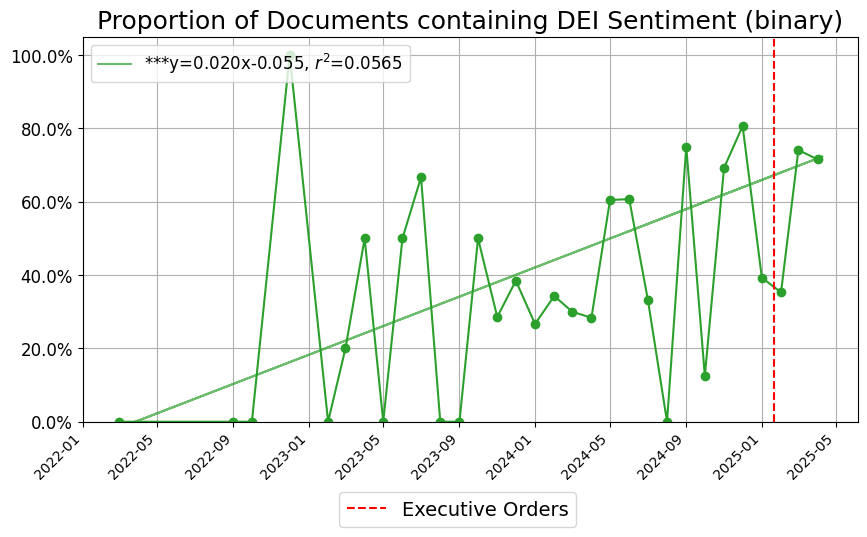

In [201]:
metrics_pairs = [
    ('auto_annotation',),
    # ('dei_narrow_count', 'dei_expanded_count'),
    # ('dei_narrow_proportion', 'dei_expanded_proportion'),
    
]
generate_plots(metrics_pairs, merged, save='figures/annotations.png')

## additional data analysis

In [202]:
merged = pd.read_csv('data/merged.csv')
merged.columns

Index(['Unnamed: 0', 'job_title', 'job_posted_date', 'company_name',
       'job_description_text', 'num_applications', 'contract_type',
       'seniority_level', 'work_type', 'sector',
       ...
       'dedication_count', 'viewpoints_count', 'foster_count', 'fun_count',
       'gritty_count', 'dei_narrow_count', 'dei_expanded_count',
       'total_word_count', 'dei_narrow_proportion', 'dei_expanded_proportion'],
      dtype='object', length=108)

Linear regression for dei_narrow_count: y=0.001701x + -32.212888, r^2=0.0200, p=0.0000 ***, std_err=0.000277
Linear regression for dei_expanded_count: y=0.012788x + -242.616218, r^2=0.0519, p=0.0000 ***, std_err=0.001273
Linear regression for dei_narrow_proportion: y=0.000001x + -0.013482, r^2=0.0020, p=0.0570 , std_err=0.000000
Linear regression for dei_expanded_proportion: y=0.000007x + -0.129020, r^2=0.0159, p=0.0000 ***, std_err=0.000001
Linear regression for auto_annotation: y=0.000652x + -12.445956, r^2=0.0565, p=0.0000 ***, std_err=0.000062


/tmp/ipykernel_103899/1131462451.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])
/tmp/ipykernel_103899/1131462451.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])


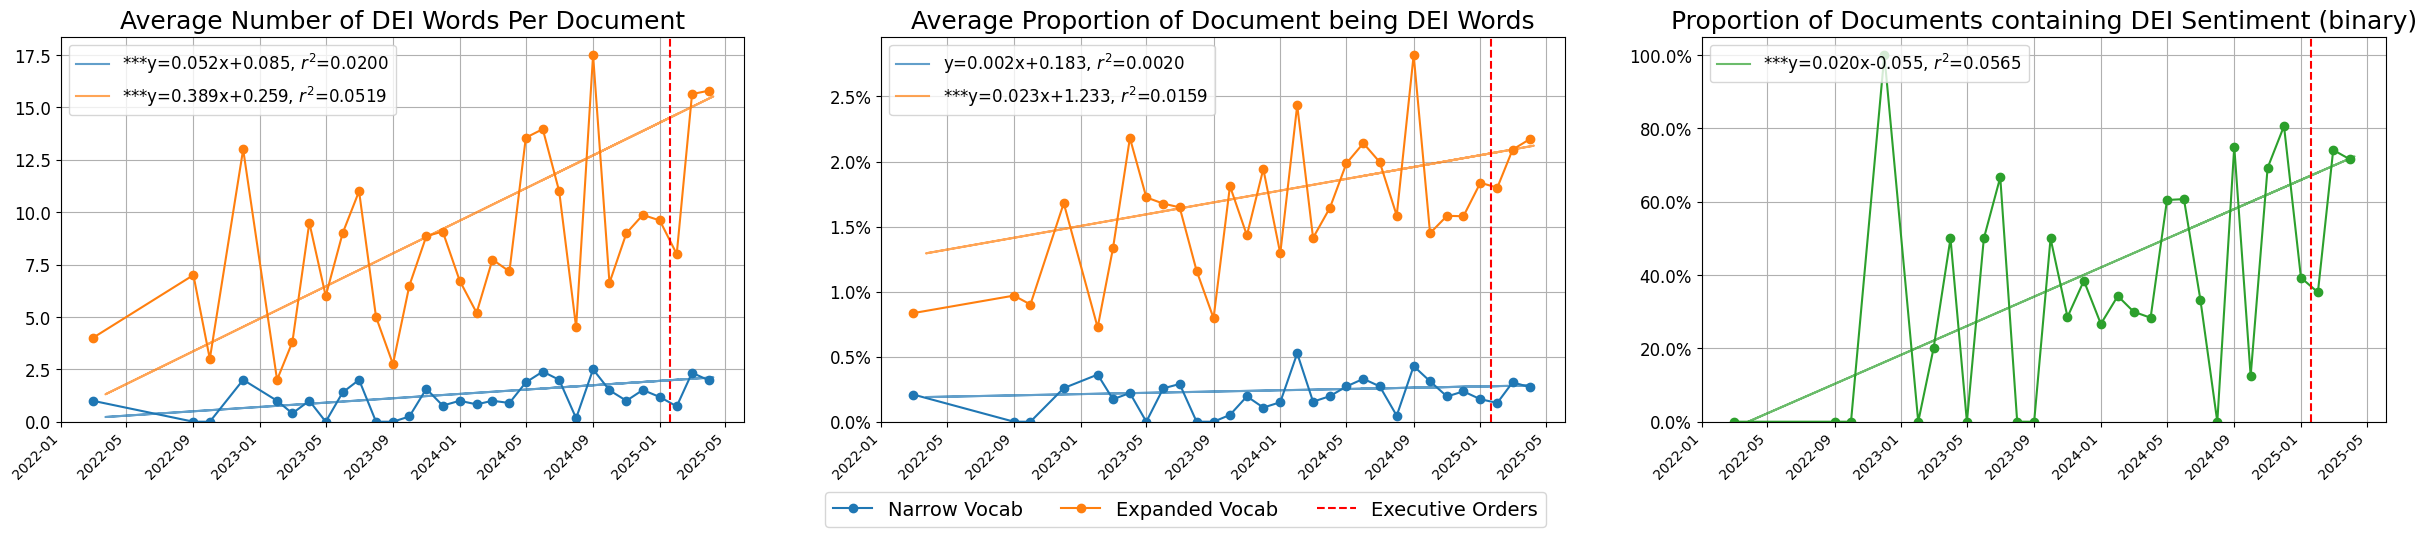

In [204]:
metrics = [
    ('dei_narrow_count', 'dei_expanded_count'),
    ('dei_narrow_proportion', 'dei_expanded_proportion'),
    ('auto_annotation',)
]
generate_plots(metrics, merged, save='figures/all_graphs.png')